### Working on the Thrash dataset

Needs to be done:
1. Loading the data from dataset
    1. Looking at the data and see what the dimensionality is and the quality.
2. Transforming the data to make it better for ML methods
    1. Standardscaler?
    2. Only a black and white set? (To reduce the size of the model and inputs as it would be in continues operations)
    3. Only a black/white and Green set?
3. Training using the FFNN in project 2
    1. Write the results and how we apply them here to find the optimal parameters for our model
4. Using the CNN architecture to see if it have better performance
5. Analytical Analysis of the results, looking at the wrong errors and see if it is good.
6. Comparing these results with the once in MNIST for project 2 and see if they are good.
7. Comparing these results with the research paper that utilized this dataset and other thrash spotting models.
8. Perhaps this should instead be using the 


- Perhaps using a pretrained model than train that one on the specific usecase would be better. Usage of Laura? method where one downscales the models to minimize the inference cost and have a more dense model specilaised to the specific problem.


### Cleaning the data

In [6]:
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def load_realwaste_dataset(data_dir, img_size=(128, 128), test_size=0.2, random_state=42, grayscale=False):
    """
    Load RealWaste dataset with stratified train-test split.
    
    Parameters:
    -----------
    data_dir : str
        Path to the RealWaste directory containing category folders
    img_size : tuple
        Target size for images (height, width)
    test_size : float
        Proportion of dataset to include in test split (default: 0.2)
    random_state : int
        Random seed for reproducibility
    grayscale : bool
        If True, convert images to grayscale (default: False for RGB)
    
    Returns:
    --------
    X_train, X_test, y_train, y_test : numpy arrays
        Training and test sets
    class_names : list
        List of class names corresponding to label indices
    """
    
    # Define the class folders
    class_folders = [
        'Cardboard', 'Food Organics', 'Glass', 'Metal', 
        'Miscellaneous Trash', 'Paper', 'Plastic', 
        'Textile Trash', 'Vegetation'
    ]
    
    images = []
    labels = []
    class_names = []
    
    print("Loading images from dataset...")
    for class_idx, class_name in enumerate(class_folders):
        class_path = Path(data_dir) / class_name
        if not class_path.exists():
            print(f"Warning: {class_name} folder not found at {class_path}")
            continue
            
        class_names.append(class_name)
        image_files = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))
        
        print(f"Loading {len(image_files)} images from {class_name}...")
        for img_path in image_files:
            try:
                # Load and resize image
                img = Image.open(img_path)
                
                # Convert to grayscale or RGB
                if grayscale:
                    img = img.convert('L')  # Grayscale
                else:
                    img = img.convert('RGB')  # RGB
                
                img = img.resize(img_size)
                
                # Convert to numpy array and normalize to [0, 1]
                img_array = np.array(img) / 255.0
                
                images.append(img_array)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue
    
    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)
    
    print(f"\nDataset loaded:")
    print(f"Total images: {len(X)}")
    print(f"Image shape: {X.shape[1:]}")
    print(f"Number of classes: {len(class_names)}")
    print(f"\nClass distribution:")
    for idx, class_name in enumerate(class_names):
        count = np.sum(y == idx)
        print(f"  {class_name}: {count} images")
    
    # Stratified train-test split to maintain class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"\nTrain set: {len(X_train)} images")
    print(f"Test set: {len(X_test)} images")
    print(f"\nTrain set class distribution:")
    for idx, class_name in enumerate(class_names):
        count = np.sum(y_train == idx)
        print(f"  {class_name}: {count} images ({count/len(y_train)*100:.1f}%)")
    
    return X_train, X_test, y_train, y_test, class_names

### Load the Dataset

Now let's load the RealWaste dataset with stratified splitting:

In [ ]:
# Set the path to your RealWaste dataset
data_dir = r'c:\Users\Anton\Documents\UiO Fag\FYS-STK4155 Anvendt dataanalyse og maskinlæring\Eget Arbeid\Project Work\Project 3\realwaste-main\RealWaste'

# Load the dataset (RGB version)
X_train, X_test, y_train, y_test, class_names = load_realwaste_dataset(
    data_dir=data_dir,
    img_size=(128, 128),  
    test_size=0.2,        
    random_state=42,
    grayscale=False       
)

print("\nDataset loaded successfully!")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Loading images from dataset...
Loading 461 images from Cardboard...
Loading 411 images from Food Organics...
Loading 420 images from Glass...
Loading 790 images from Metal...
Loading 495 images from Miscellaneous Trash...
Loading 500 images from Paper...
Loading 921 images from Plastic...
Loading 318 images from Textile Trash...
Loading 436 images from Vegetation...

Dataset loaded:
Total images: 4752
Image shape: (128, 128, 3)
Number of classes: 9

Class distribution:
  Cardboard: 461 images
  Food Organics: 411 images
  Glass: 420 images
  Metal: 790 images
  Miscellaneous Trash: 495 images
  Paper: 500 images
  Plastic: 921 images
  Textile Trash: 318 images
  Vegetation: 436 images

Train set: 3801 images
Test set: 951 images

Train set class distribution:
  Cardboard: 369 images (9.7%)
  Food Organics: 329 images (8.7%)
  Glass: 336 images (8.8%)
  Metal: 632 images (16.6%)
  Miscellaneous Trash: 396 images (10.4%)
  Paper: 400 images (10.5%)
  Plastic: 736 images (19.4%)
  Textil

In [5]:
y_train

array([3, 5, 8, ..., 0, 1, 8], shape=(3801,))

In [ ]:
import Functions as F

X_train_flat = X_train.reshape(X_train.shape[0], -1)
encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))


best_score, best_iteration,best_model,training_scores,testing_scores = F.run_training_experiment(X_train_flat, y_train_onehot, X_test.reshape(X_test.shape[0], -1), y_test_onehot,
                          n_epochs=3, method="Adam", batch_size=64, learning_rate=0.01,
                             activation_funcs=[F.sigmoid]*4 + [F.softmax], 
                             activation_ders=[F.der_sigmoid]*4 + [F.der_softmax], 
                             layer_sizes=[1000,700,500,300] + [len(class_names)],
                             cost_func=F.cross_entropy,
                             cost_der_func=F.der_softmax, 
                             Regularization_type="L1", 
                             lambda_reg=1e-3,
                             best_model_iteration=True)

c:\Users\Anton\Documents\UiO Fag\FYS-STK4155 Anvendt dataanalyse og maskinlæring\Eget Arbeid\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


In [19]:
final_cost = best_model.cost(X_test.reshape(X_test.shape[0], -1), y_test_onehot)
print(f"Final Test on Thrash: {final_cost:.6f}")

test_predictions = best_model.predict(X_test.reshape(X_test.shape[0], -1))
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test_onehot, axis=1)

accuracy = np.mean(predicted_labels == true_labels)
print(f"Final Test Accuracy on Thrash: {accuracy * 100:.2f}%")

test_predictions = best_model.predict(X_test.reshape(X_test.shape[0], -1))
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test_onehot, axis=1)

accuracy = np.mean(predicted_labels == true_labels)
print(f"Final Test Accuracy on Thrash: {accuracy * 100:.2f}%")

Final Test on Thrash: 2.144093
Final Test Accuracy on Thrash: 19.45%
Final Test Accuracy on Thrash: 19.45%


Final Test Cross Entropy with best parameters: 2.144093 at 44 epochs


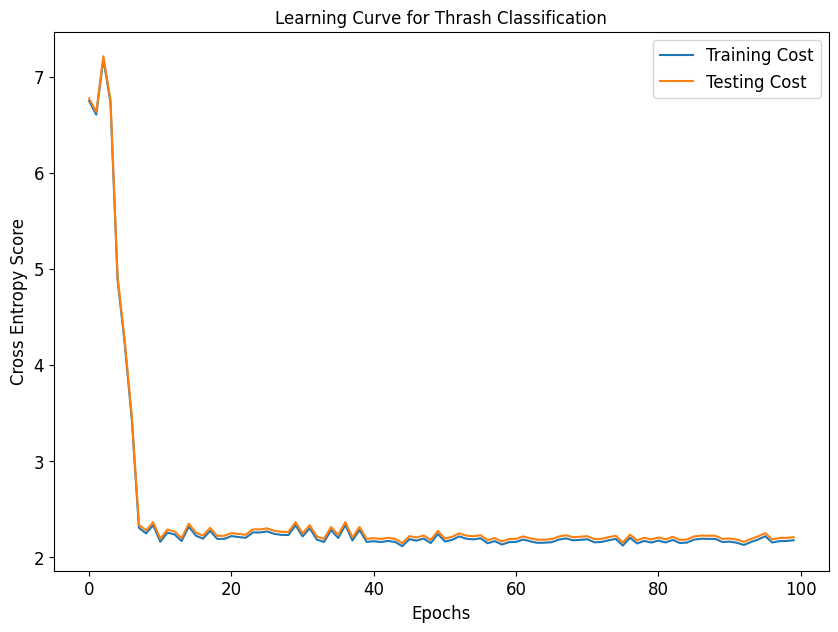

In [20]:
print(f"Final Test Cross Entropy with best parameters: {best_score:.6f} at {best_iteration} epochs")
fig , ax = plt.subplots(figsize=(10,7))
ax.plot(training_scores, label=f'Training Cost')
ax.plot(testing_scores, label=f'Testing Cost ')
ax.set_title(f'Learning Curve for Thrash Classification', fontsize=12)
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Cross Entropy Score', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
plt.savefig("Thrash_Learning_Curve.png")
plt.show()

In [27]:
import Functions as F

X_train_flat = X_train.reshape(X_train.shape[0], -1)
encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))


best_score_2, best_iteration_2,best_model_2,training_scores_2,testing_scores_2 = F.run_training_experiment(X_train_flat, y_train_onehot, X_test.reshape(X_test.shape[0], -1), y_test_onehot,
                          n_epochs=10, method="Adam", batch_size=32, learning_rate=0.01,
                             activation_funcs=[F.sigmoid,F.ReLU,F.sigmoid,F.ReLU, F.sigmoid] + [F.softmax], 
                             activation_ders=[F.der_sigmoid,F.der_ReLU,F.der_sigmoid,F.der_ReLU,F.der_sigmoid] + [F.der_softmax], 
                             layer_sizes=[1000,700,700,500,300] + [len(class_names)],
                             cost_func=F.cross_entropy,
                             cost_der_func=F.der_softmax, 
                             Regularization_type="L1", 
                             lambda_reg=1e-4,
                             best_model_iteration=True)

c:\Users\Anton\Documents\UiO Fag\FYS-STK4155 Anvendt dataanalyse og maskinlæring\Eget Arbeid\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


In [26]:
final_cost = best_model_2.cost(X_test.reshape(X_test.shape[0], -1), y_test_onehot)
print(f"Final Test on Thrash: {final_cost:.6f}")

test_predictions = best_model_2.predict(X_test.reshape(X_test.shape[0], -1))
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test_onehot, axis=1)

accuracy = np.mean(predicted_labels == true_labels)
print(f"Final Test Accuracy on Thrash: {accuracy * 100:.2f}%")

test_predictions = best_model.predict(X_test.reshape(X_test.shape[0], -1))
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test_onehot, axis=1)

accuracy = np.mean(predicted_labels == true_labels)
print(f"Final Test Accuracy on Thrash: {accuracy * 100:.2f}%")

Final Test on Thrash: 2.240676
Final Test Accuracy on Thrash: 13.56%
Final Test Accuracy on Thrash: 19.45%


Final Test Cross Entropy with best parameters: 2.144093 at 44 epochs


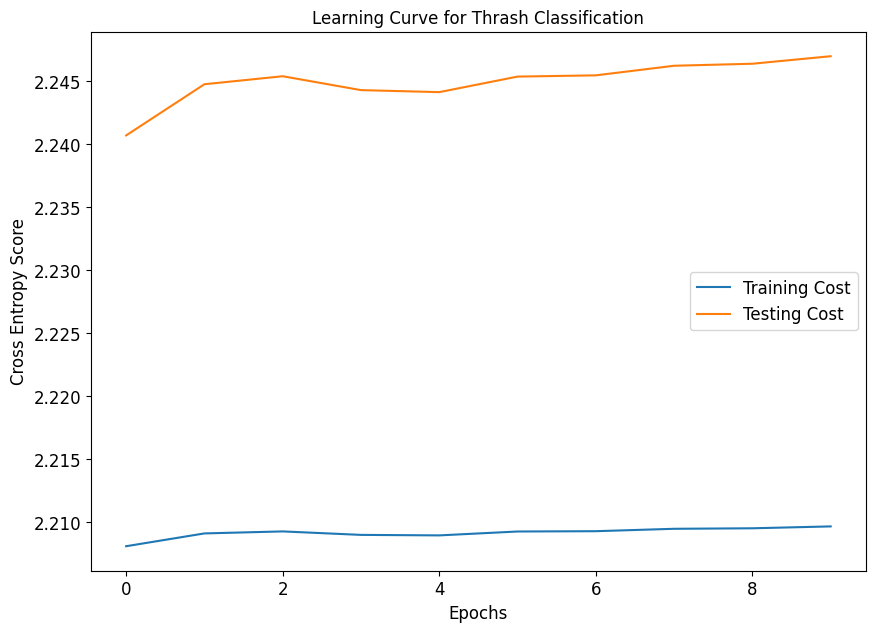

In [25]:
print(f"Final Test Cross Entropy with best parameters: {best_score:.6f} at {best_iteration} epochs")
fig , ax = plt.subplots(figsize=(10,7))
ax.plot(training_scores_2, label=f'Training Cost')
ax.plot(testing_scores_2, label=f'Testing Cost ')
ax.set_title(f'Learning Curve for Thrash Classification', fontsize=12)
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Cross Entropy Score', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
plt.savefig("Thrash_Learning_Curve_2.png")
plt.show()

### Creating more data by roations etc..

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models